### [andrewslotnick.com](http://andrewslotnick.com)
---
# Speeding Up a Speech

I was watching a presentation recently and found myself using Youtube's "speed" setting to speed up the speaker's delivery. In this post I'll try to replicate that functionality using Python, and I'll try out a technique to remove pauses without changing the length of each word.

Audio input and output will be handled by [scipy.io.wavfile](http://docs.scipy.org/doc/scipy/reference/io.html#module-scipy.io.wavfile), and transformations will be performed using numpy ndarrays.

As an example piece of audio, I've downloaded a 28-second clip of a recent Tesla product announcement.


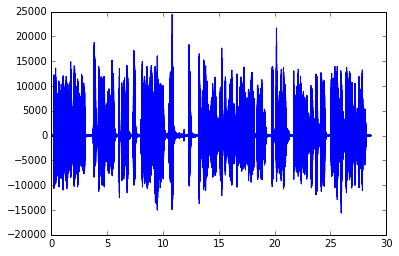

In [1]:
import numpy
from scipy.io import wavfile
from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

speech_rate, speech_data = wavfile.read('wavs/elon_mono.wav')
plt.plot(numpy.arange(speech_data.size)/speech_rate, speech_data)
Audio(url='https://s3.amazonaws.com/audio-experiments/examples/elon_mono.wav')

## Resampling
If we want to listen to an audio clip in less time, a simplistic technique is to playback the same samples at a faster rate. The audio clip was encoded at a rate of 44100 samples per second and takes 28 seconds to playback. If we re-encode it at a 1.3 times the rate, it should play back 1.3 times faster.

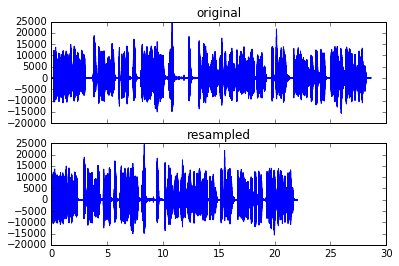

In [2]:
#increase sample rate to speed up the audio, also increasing pitch
wavfile.write('wavs/elon_mono_130.wav', int(speech_rate*1.3), speech_data)

f, plots = plt.subplots(2, sharex=True)
plots[0].set_title('original')
plots[0].plot(numpy.arange(speech_data.size)/speech_rate, speech_data)
plots[1].set_title('resampled')
plots[1].plot(numpy.arange(speech_data.size)/int(speech_rate*1.3), speech_data)
Audio(url='https://s3.amazonaws.com/audio-experiments/examples/elon_mono_130.wav')

This reduced the time as expected, but it also increased the pitch. Since pitch is our perception of frequency, and frequency is how quickly something happens, it makes sense that by increasing the speed of playback we've also increased the pitch.

## Overlap
Instead of speeding everything up equally, what if we broke up the clip into pieces and moved the pieces closer together? The beginning and end of each piece would overlap, but the frequencies of the samples themselves wouldn't change. 

We'll start with an array of zeros the length of the original minus the number of samples that will be overlapped. Then add the samples from each piece, or window, from the original to the new clip such that they overlap part of the previous window.

Using 1000 windows and overlapping the last 441 samples of each window with the first 441 of the next should reduce the time by 10 seconds (441 samples * 1000 windows / 44100 samples per second).


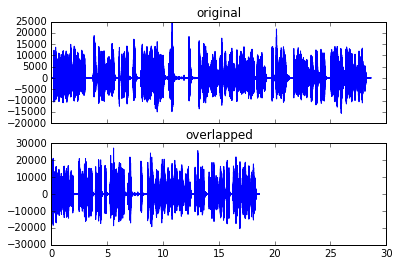

In [3]:
num_windows = 1000
overlap = 441
window_size = int(speech_data.size/num_windows)

overlapped = numpy.zeros(speech_data.size-(num_windows*overlap), dtype='int16')
for i in range(0, num_windows):
    read_start = i*window_size
    write_start = read_start-(i*overlap)
    overlapped[write_start:(write_start+window_size)] += speech_data[read_start:(read_start+window_size)]
    
wavfile.write('wavs/elon_mono_overlapped.wav', int(speech_rate), overlapped)
f, plots = plt.subplots(2, sharex=True)
plots[0].set_title('original')
plots[0].plot(numpy.arange(speech_data.size)/speech_rate, speech_data)
plots[1].set_title('overlapped')
plots[1].plot(numpy.arange(overlapped.size)/speech_rate, overlapped)
Audio(url='https://s3.amazonaws.com/audio-experiments/examples/elon_mono_overlapped.wav')

This result is pretty good. We've reduced the time to listen to this clip without altering the pitch. However, because this is a naive implementation which performs this overlap technique on audio in the time domain, the result is noisy (making Elon sound a bit like a [Dalek](https://www.youtube.com/watch?v=mxD-5z_xHBU)).

A better way to apply this technique is known as a ["phase vocoder"](https://en.wikipedia.org/wiki/Phase_vocoder). It requires converting the audio into the frequency domain using the short-time Fourier transform ([STFT](https://en.wikipedia.org/wiki/Short-time_Fourier_transform)), combining the windows in a way that minimizes noise, then converting back to time domain with an inverse STFT. Implementing this is beyond my expertise at the moment, but luckily [Brian McFee](http://bmcfee.github.io/) has written a Python implementation in the excellent [librosa](https://github.com/bmcfee/librosa) library. 

Librosa's time_stretch method will allow us to scale the audio and avoid creating sound artifacts.

More info on the phase vocoder:
https://github.com/bmcfee/librosa/blob/v0.4.0/librosa/core/spectrum.py#L484
http://www.ee.columbia.edu/~dpwe/resources/matlab/pvoc/

/Volumes/365/2015/miniconda/envs/audio/lib/python3.4/site-packages/librosa/core/audio.py:37: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


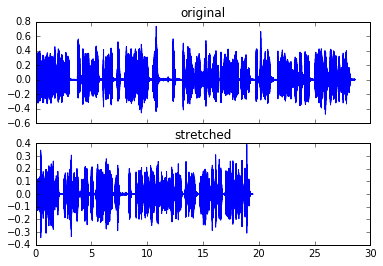

In [4]:
import librosa
#reload the audio to use librosa's expected format
lr_speech_data, lr_speech_rate  = librosa.load('wavs/elon_mono.wav')

stretched = librosa.effects.time_stretch(lr_speech_data, 1.47)

wavfile.write('wavs/elon_mono_stretched.wav', lr_speech_rate, stretched)
f, plots = plt.subplots(2, sharex=True)
plots[0].set_title('original')
plots[0].plot(numpy.arange(lr_speech_data.size)/lr_speech_rate, lr_speech_data)
plots[1].set_title('stretched')
plots[1].plot(numpy.arange(stretched.size)/lr_speech_rate, stretched)
Audio(url='https://s3.amazonaws.com/audio-experiments/examples/elon_mono_stretched.wav')

This is the best result so far. The audio clip has been sped up with no change in pitch, and no noise added. There's some slight distortion that's occurred but that could likely be optimized by playing with the additional options for time_stretch. 

Wikipedia has some additional discussion of these techniques: [Audio_time-scale/pitch_modification](https://en.wikipedia.org/wiki/Audio_time-scale/pitch_modification)

## Remove Silence
Although the phase vocoder let's us listen to this clip in less time, it speeds up all parts of the speech equally. It would be nice to be able to skip over the sections of silence and crowd noise to only hear the speaker's words.

You can find examples of this feature in some podcasting apps as well as a production implementation in the open-source audio editor [Audacity](http://manual.audacityteam.org/index.php?title=Truncate_Silence). There's not likely to be sections of actual silence in the audio clip due to background noise, so what we really want to do is remove any sounds lower than a particlar threshold.

First pick a threshold, identify all samples above the threshold value, and return an array including only those samples. Wavfile.read returns an array with samples above and below zero, so I compare the absolute value of the sample to the threshold.

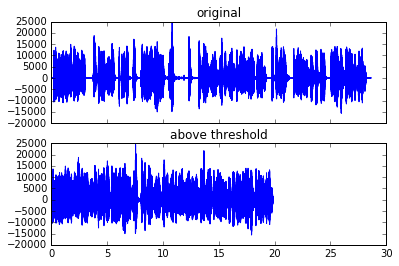

In [5]:
#threshold determined by experimentation
threshold = 125

#identify all samples with an absolute value greater than the threshold
greater_index = numpy.greater(numpy.absolute(speech_data), threshold)
#filter to only include the identified samples
above_threshold_data = speech_data[greater_index]

wavfile.write('wavs/elon_mono_threshold.wav', speech_rate, above_threshold_data)
f, plots = plt.subplots(2, sharex=True)
plots[0].set_title('original')
plots[0].plot(numpy.arange(speech_data.size)/speech_rate, speech_data)
plots[1].set_title('above threshold')
plots[1].plot(numpy.arange(above_threshold_data.size)/speech_rate, above_threshold_data)
Audio(url='https://s3.amazonaws.com/audio-experiments/examples/elon_mono_threshold.wav')

With this result, we've cut off almost a third of the clip without changing the speed of the words. Subjectively, I find this a little bit easier to listen to then the time_stretched version. 

To see how much impact removing silences can have, let's try it on a much larger audio clip: the 2016 State of the Union address. This audio comes in at just under 59 minutes.

/Volumes/365/2015/miniconda/envs/audio/lib/python3.4/site-packages/scipy/io/wavfile.py:221: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


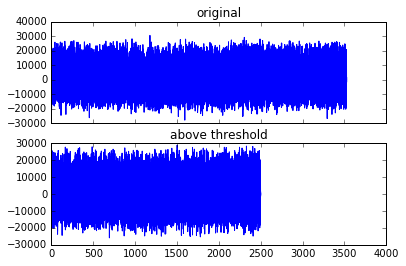

In [6]:
sotu_rate, sotu_data = wavfile.read('wavs/SOTU2016.wav')

def remove_silence(audio, threshold ):
    #identify all samples with an absolute value greater than the threshold
    greater_index = numpy.greater(numpy.absolute(audio), threshold)
    #filter to only include the identified samples
    above_threshold_data = audio[greater_index]
    return above_threshold_data

sotu_above_threshold = remove_silence(sotu_data, 200)
#write only the first 20 seconds for evaluation
wavfile.write('wavs/sotu_threshold.wav', sotu_rate, sotu_above_threshold[:sotu_rate*20])
f, plots = plt.subplots(2, sharex=True)
plots[0].set_title('original')
#plot only 1% of points to save some RAM
indices = numpy.arange(0, sotu_data.size, 100)
plots[0].plot(indices/sotu_rate, sotu_data[indices])
plots[1].set_title('above threshold')
threshold_indices = numpy.arange(0, sotu_above_threshold.size, 100)
plots[1].plot(threshold_indices/sotu_rate, sotu_above_threshold[threshold_indices])
Audio(url='https://s3.amazonaws.com/audio-experiments/examples/sotu_threshold.wav')

Using an arbitrary threshold value of 200 reduces to the speech to 42 minutes, a reduction of 27% -- not bad.

